<a href="https://colab.research.google.com/github/ipavlopoulos/palit/blob/main/code/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import pandas as pd
import skimage
import random
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import figure
from sklearn.metrics import *
from skimage import transform
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import xgboost as xgb 

In [3]:
%%capture
!gdown 1kNgqJCFZS4Q-P2YSaeaYp9P2bTobyOCV
pll = pd.read_pickle("pll.csv")

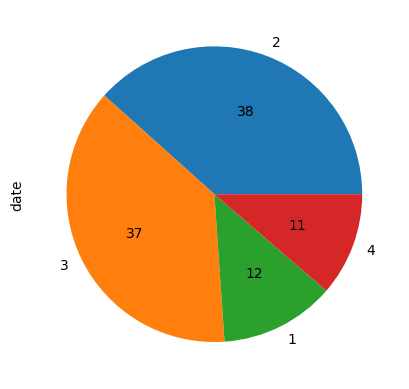

In [4]:
pll.date.value_counts().plot.pie(autopct=f'%d');

In [5]:
dataset = pll.explode("img")
dataset = dataset[dataset.img.notna()]

In [6]:
print("Lines num:", dataset.shape[0])

w,h = 300,50
img_data = pd.DataFrame(dataset.img.apply(lambda x: x.shape).tolist(), index=dataset.index, columns=["H", "W"])
dataset = dataset[(img_data.W>w)&(img_data.H>h)]
dataset.insert(0, "lid", range(1, dataset.shape[0]+1))
print(f'After preprocessing --> {dataset.shape[0]}')

Lines num: 4717
After preprocessing --> 2774


2218 278 278


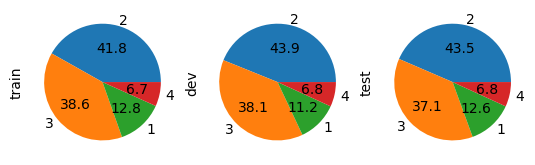

In [7]:
# uncomment for the xsplit
#testmod = 13
#pll_test = dataset[dataset.uid%testmod==0]
#pll_test, pll_val = train_test_split(pll_test, test_size=pll_test.shape[0]//2, random_state=2021)
#pll_train = dataset[dataset.uid%testmod!=0]
pll_train, pll_test = train_test_split(dataset, test_size=0.1, random_state=2023)
pll_train, pll_val = train_test_split(pll_train, test_size=pll_test.shape[0], random_state=2023)
print(pll_train.shape[0], pll_val.shape[0], pll_test.shape[0])
pd.DataFrame({"train": pll_train.date.value_counts(),                
              "dev": pll_val.date.value_counts(),
              "test":pll_test.date.value_counts()}).plot.pie(subplots=True, autopct=f'%.1f', legend=False);

In [8]:
# quantifying the leak
pll_test['leak'] = pll_test.uid.isin(set(pll_train.uid.unique()))
pll_test.leak.sum()

278

In [9]:
# majority baseline
blm = lambda images, major=2: [major for img in images]
truth_col = "date"
labels = pll_test[truth_col].values
blm_preds = blm(pll_test.img.values)
print(f"MAE: {mean_absolute_error(labels, blm_preds):.3f}")
print(f"MSE: {mean_squared_error(labels, blm_preds):.3f}")

MAE: 0.633
MSE: 0.770


In [10]:
from sklearn.decomposition import PCA
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier

# DATA PREPARATION
def process(dataset, input_col="img", h=50, w=300, center=True): 
    images = dataset[input_col]
    if center:
        crop = lambda x: x[(x.shape[0]//2)-(h//2):(x.shape[0]//2)+(h//2),(x.shape[1]//2)-(w//2):(x.shape[1]//2)+(w//2)]
        images = images.apply(crop) # center cropping
        images = images.apply(lambda img: skimage.transform.resize(img, (h, w)))
    return np.concatenate(images.to_numpy()).reshape(dataset.shape[0], h*w)

pca = PCA(n_components=500)
X_processed = process(pll_train)
pca.fit(X_processed)
X = pca.transform(X_processed)
X_test = pca.transform(process(pll_test))

#### Visualising an image with and without PCA-based compression

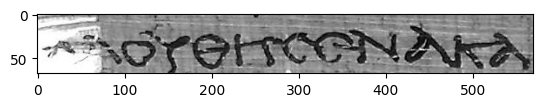

In [11]:
plt.imshow(pll_test.iloc[2].img, cmap="gray");

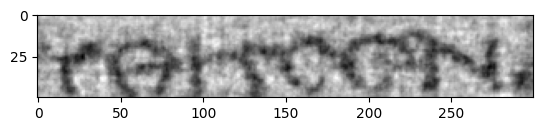

In [12]:
plt.imshow(pca.inverse_transform(X_test[2]).reshape((50, 300)), cmap="gray");

In [13]:
from skimage.filters import threshold_otsu
from skimage import feature

class Majority:
    
    def __init__(self, major=2):
        self.major = major
        
    def predict(self, images):
        return [self.major for img in images]

class Baseline:

    def __init__(self, train, val, algorithm, truth_col="date", components=-1, fit=False, otsu=False, canny=False, center=True):
        assert not (otsu and canny) # do not allow both of these true
        self.train = train
        self.val = val
        self.otsu = otsu
        self.canny = canny
        self.center = center
        X_processed = process(train)
        self.X = X_processed
        self.X_val = self.process(val)
        self.components = components
        if self.components>0:
            self.pca = PCA(n_components=self.components)
            self.pca.fit(self.X)
            self.X = self.pca.transform(self.X)
            self.X_val = pca.transform(self.X_val)
        self.truth_col = truth_col
        self.algorithm = algorithm
        self.fit = fit
        if self.fit:
            print("Fitting, this may take several minutes...")
            self.algorithm.fit(self.X, self.train[self.truth_col].values)        
            
    def process(self, dataset, input_col="img", h=50, w=300, center=True):
        images = dataset[input_col]
        if self.center:
            crop = lambda x: x[(x.shape[0]//2)-(h//2):(x.shape[0]//2)+(h//2),(x.shape[1]//2)-(w//2):(x.shape[1]//2)+(w//2)]
            images = images.apply(crop) # center cropping
            images = images.apply(lambda img: skimage.transform.resize(img, (h, w)))
        if self.otsu:
            images = images.apply(lambda img: img > threshold_otsu(img))
        if self.canny:
            images = images.apply(lambda img: feature.canny(img))
        return np.concatenate(images.to_numpy()).reshape(dataset.shape[0], h*w)

    def predict(self, test):
        x_test = self.process(test)
        if self.components>0:
            x_test = self.pca.transform(x_test)
        predictions = self.algorithm.predict(x_test)
        return predictions
    
    def assess(self, test):
        predictions = self.predict(test)
        y_test = test[self.truth_col].values
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        return predictions, mae, mse


In [14]:
blm = Baseline(pll_train, pll_val, algorithm=Majority())
blm_predictions, mae, mse = blm.assess(pll_test)
print(f"Majority\nMAE: {mae:.3f}\nMSE: {mse:.3f}")

Majority
MAE: 0.633
MSE: 0.770


In [15]:
bootstrap = lambda test, algo, size=0.2: algo.assess(test.sample(int(test.shape[0]*size)))
def sstest(test, baseline, sample_size=0.5, repetitions=20):
    mae, mse = [], []
    for i in range(repetitions): 
        r = bootstrap(test, baseline, size=sample_size)
        mae.append(r[1]); mse.append(r[2])
    return pd.DataFrame({"mae":mae, "mse":mse})

stats = ["mean", "std", "sem", "min", "max"]
sstest(pll_test, blm).agg(stats)

,mae,mse
mean,0.636331,0.775899
std,0.026146,0.058923
sem,0.005846,0.013176
min,0.575540,0.647482
max,0.683453,0.870504


Fitting, this may take several minutes...
XGBoost
MAE: 0.650
MSE: 0.646


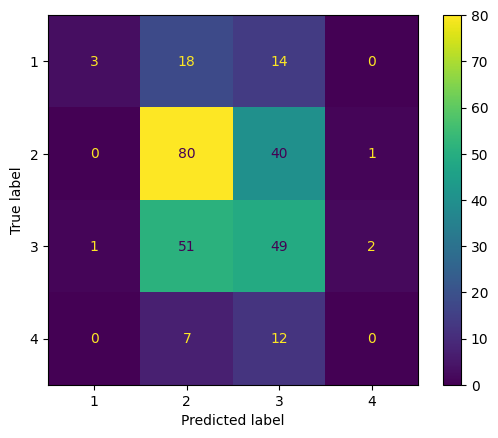

In [16]:
gxb = Baseline(pll_train, pll_val, algorithm=xgb.XGBRegressor(objective="reg:squarederror"), fit=True, components=500)
gxb_predictions, mae, mse = gxb.assess(pll_test)
print(f"XGBoost\nMAE: {mae:.3f}\nMSE: {mse:.3f}")
gxb_cm = ConfusionMatrixDisplay.from_predictions(pll_test[truth_col].apply(str).values, [str(round(p)) for p in gxb_predictions])

In [17]:
sstest(pll_test, gxb).agg(stats)

,mae,mse
mean,0.654637,0.660479
std,0.023423,0.048064
sem,0.005237,0.010747
min,0.609303,0.583570
max,0.697668,0.752138


Fitting, this may take several minutes...
Extra Trees
MAE: 0.648
MSE: 0.583


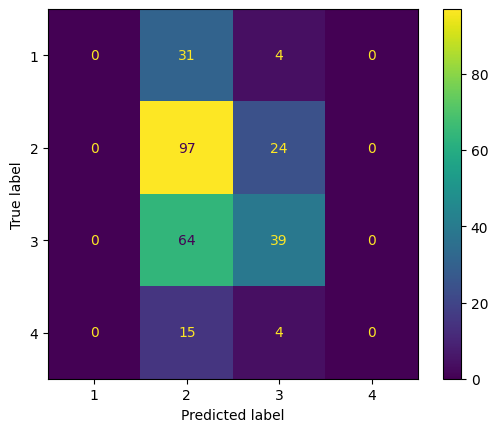

In [18]:
xtr = Baseline(pll_train, pll_val, algorithm=ExtraTreesRegressor(), fit=True, components=500)
xtr_predictions, mae, mse = xtr.assess(pll_test)
print(f"Extra Trees\nMAE: {mae:.3f}\nMSE: {mse:.3f}")
xtr_cm = ConfusionMatrixDisplay.from_predictions(pll_test[truth_col].apply(str).values, [str(round(p)) for p in xtr_predictions])

In [19]:
sstest(pll_test, xtr).agg(stats)

,mae,mse
mean,0.643158,0.573967
std,0.025777,0.048395
sem,0.005764,0.010821
min,0.594676,0.492137
max,0.695899,0.681139


## Image filtering
* Otsu appears to binarise the papyri well

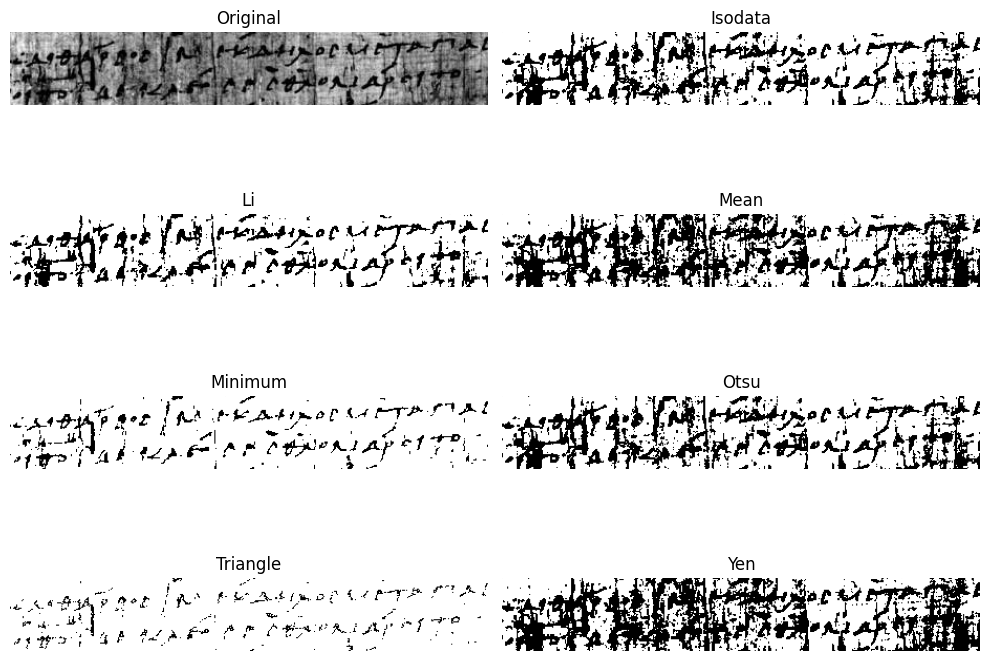

In [20]:
from skimage.filters import try_all_threshold

img = pll_train.sample().img.item()

fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

Fitting, this may take several minutes...
XGBoost (using Otsu)
MAE: 0.764
MSE: 0.939


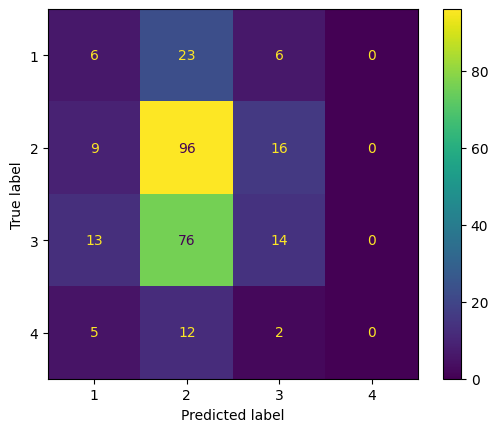

In [21]:
gxb_otsu = Baseline(pll_train, pll_val, algorithm=xgb.XGBRegressor(objective="reg:squarederror"), fit=True, otsu=True)
gxb_otsu_predictions, mae, mse = gxb_otsu.assess(pll_test)
print(f"XGBoost (using Otsu)\nMAE: {mae:.3f}\nMSE: {mse:.3f}")
gxb_cm = ConfusionMatrixDisplay.from_predictions(pll_test[truth_col].apply(str).values, [str(round(p)) for p in gxb_otsu_predictions])

* Canny edge doesn't help either

Fitting, this may take several minutes...
XGBoost (using Canny)
MAE: 0.791
MSE: 0.956


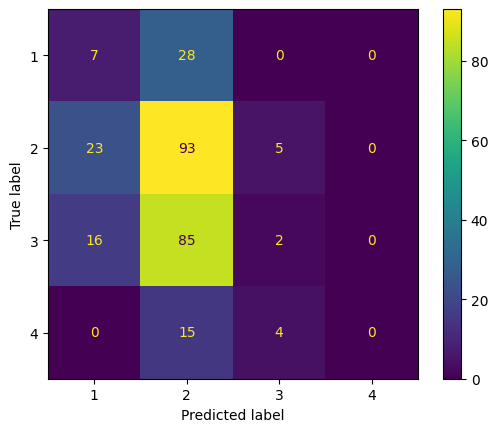

In [22]:
gxb_canny = Baseline(pll_train, pll_val, algorithm=xgb.XGBRegressor(objective="reg:squarederror"), fit=True, canny=True)
gxb_canny_predictions, mae, mse = gxb_canny.assess(pll_test)
print(f"XGBoost (using Canny)\nMAE: {mae:.3f}\nMSE: {mse:.3f}")
gxb_cm = ConfusionMatrixDisplay.from_predictions(pll_test[truth_col].apply(str).values, [str(round(p)) for p in gxb_canny_predictions])